# NN hyperparamter optimisation using Talos

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

sklearn.set_config(transform_output="pandas")

import tensorflow as tf
from tensorflow import keras

# tf.debugging.set_log_device_placement(True)

keras.backend.clear_session()
keras.utils.set_random_seed(2)

2023-11-09 15:30:00.179850: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-09 15:30:00.223258: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 15:30:00.223287: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 15:30:00.223311: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 15:30:00.231947: I tensorflow/core/platform/cpu_feature_g

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin


class LibraryLengthNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Normalise the gene counts to the library size
        X = X.apply(lambda x: (x / (x.sum() if x.sum() != 0 else 1)) * 1000000)
        return X

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


def to_normalize_rpm(data):
    # Normalise the gene counts to the library size
    data = data.apply(lambda x: (x / (x.sum() if x.sum() != 0 else 1)) * 1000000)
    return data


def data_prep_pca_log(data):
    data = data.loc[:, data.sum(axis=0) > 10]
    data = to_normalize_rpm(data)
    data = np.log1p(data)
    data = scaler.fit_transform(data)
    return data


def data_prep_pca(data):
    data = data.loc[:, data.sum(axis=0) > 10]
    data = to_normalize_rpm(data)
    data = scaler.fit_transform(data)
    return data

In [4]:
file_name = "/home/t.afanasyeva/MATseq/notebooks/gene_counts_NN_55_training.csv"

data = pd.read_csv(file_name)
labels = data["sample"]
features = data.drop(columns=["sample"])

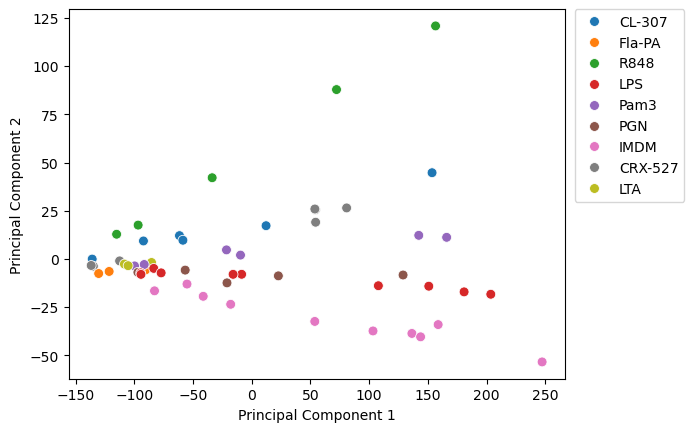

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_processed = data_prep_pca(features)
pca = pca.fit_transform(features_processed)

scatter = sns.scatterplot(
    x=pca.pca0,
    y=pca.pca1,
    hue=labels,
    s=50,
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

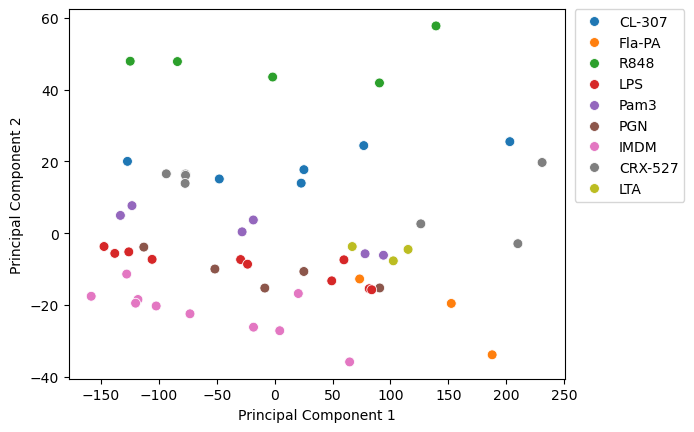

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_processed = data_prep_pca_log(features)
features_processed_pca = pca.fit_transform(features_processed)

scatter = sns.scatterplot(
    x=features_processed_pca.pca0,
    y=features_processed_pca.pca1,
    hue=labels,
    s=50,
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

In [16]:
pca.explained_variance_ratio_

array([0.6779353 , 0.02703631])

In [22]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=4)
outliers = clf.fit_predict(features)
mask = [outlier != -1 for outlier in outliers]
features = features[mask]
labels = labels[mask]
features = features.reset_index(drop=True)
labels = labels.reset_index(drop=True)

In [8]:
from sklearn.model_selection import train_test_split

split_params = {
    "test_size": 0.2,
    "random_state": 0,
    "shuffle": True,
}


X_train, X_test, y_train, y_test = train_test_split(
    features,
    labels,
    **split_params,
    stratify=labels,
)

In [23]:
# from sklearn.ensemble import ExtraTreesClassifier

# TOP_FEATURES = 800

# forest = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1)
# forest.fit(X_train, y_train)

# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# indices = np.argsort(importances)[::-1]
# indices = indices[:TOP_FEATURES]

# print("Top features:")
# for f in range(TOP_FEATURES):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

In [24]:
# plt.figure()
# plt.title("Top feature importances")
# plt.bar(
#     range(TOP_FEATURES),
#     importances[indices],
#     yerr=std[indices],
# )
# plt.xticks(range(TOP_FEATURES), indices)
# plt.show()

In [25]:
# forest_importances = pd.Series(importances, index=X_train.columns)
# important_featues = []
# for feature in forest_importances.index:
#     if forest_importances.loc[feature] > 0.001:
#         important_featues.append(feature)

# len(important_featues)

<Axes: title={'center': 'Count (target)'}, xlabel='target'>

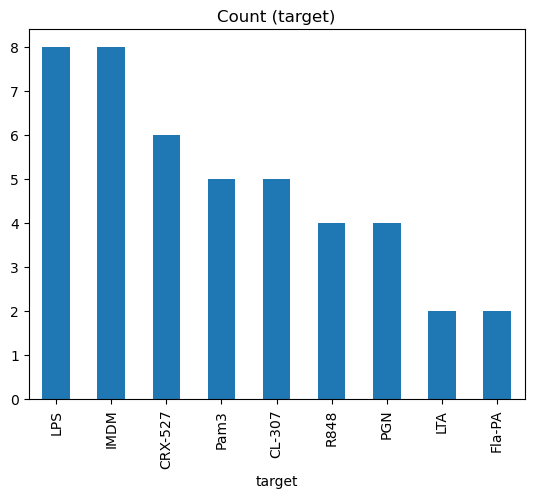

In [9]:
df = pd.DataFrame(X_train, columns=y_train)
df["target"] = y_train

df["target"].value_counts().plot(kind="bar", title="Count (target)")

In [27]:
# from imblearn.over_sampling import SMOTE

# oversample = SMOTE(sampling_strategy="not majority", k_neighbors=1)

# X_os, y_os = oversample.fit_resample(X_train, y_train)

# df = pd.DataFrame(X_os, columns=y_train)
# df["target"] = y_os

# df["target"].value_counts().plot(kind="bar", title="Count (target)")

In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [30]:
import time
from sklearn.pipeline import Pipeline
from feature_engine.selection import (
    DropDuplicateFeatures,
    DropConstantFeatures,
    DropCorrelatedFeatures,
)
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import PowerTransformer, StandardScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

forest = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1)


feature_transformer = Pipeline(
    [
        ("drop_duplicates", DropDuplicateFeatures()),
        ("drop_constant_feature", DropConstantFeatures(tol=0.50)),
        ("normalise_for_library_size", LibraryLengthNormalizer()),
        ("cap_outliers", Winsorizer(capping_method="gaussian", tail="right", fold=3)),
    ]
)

feature_selector = Pipeline(
    [
        ("select_k_best", SelectKBest(chi2, k=1000)),
        (
            "trasnform_and_scale",
            PowerTransformer(method="yeo-johnson", standardize=True),
        ),
        ("select_forest", SelectFromModel(forest, max_features=500)),
    ]
)

print("Number of features before: ", X_train.shape[1])
start_time = time.time()


X_train = feature_transformer.fit_transform(X_train)
X_test = feature_transformer.transform(X_test)

feature_selector.fit(X_train, y_train)
X_train = feature_selector.transform(X_train)
X_test = feature_selector.transform(X_test)

end_time = time.time()
print("Number of features after: ", X_train.shape[1])
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Number of features before:  19992


Number of features after:  352
Elapsed time: 32.86808776855469 seconds


In [31]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy="not majority", k_neighbors=1)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [32]:
# # bootstrap predictions
# accuracy = []
# n_iterations = 1000
# for i in range(n_iterations):
#     X_bs, y_bs = resample(x_train, y_train, replace=True)
#     # make predictions
#     y_hat = reg.predict(X_bs)
#     # evaluate model
#     score = accuracy_score(y_bs, y_hat)
#     accuracy.append(score)

In [33]:
# from tensorflow.keras.initializers import HeUniform
# from talos.utils import lr_normalizer


# def model(X_train, y_train, X_val, y_val):

#     batch_size = params.batch_size
#     activation = params.activation
#     weights_limit = params.weights_limit
#     epochs = params.epochs
#     learning_rate = params.learning_rate
#     loss = params.loss
#     l1 = params.l1
#     l2 = params.l2
#     l3 = params.l3
#     dropout_rate1 = params.dropout_rate1
#     dropout_rate2 = params.dropout_rate2
#     dropout_rate3 = params.dropout_rate3

#     inputs = keras.Input(shape=X_train.shape[1])
#     x = keras.layers.UnitNormalization()(inputs)

#     x = keras.layers.Dense(
#         l1,
#         activation=activation,
#         kernel_regularizer=keras.regularizers.L2(weights_limit),
#         kernel_initializer=HeUniform(),
#     )(x)
#     x = keras.layers.Dropout(dropout_rate1)(x)

#     x = keras.layers.Dense(
#         l2,
#         activation=activation,
#         kernel_regularizer=keras.regularizers.L2(weights_limit),
#         kernel_initializer=HeUniform(),
#     )(x)
#     x = keras.layers.Dropout(dropout_rate2)(x)

#     x = keras.layers.Dense(
#         l3,
#         activation=activation,
#         kernel_regularizer=keras.regularizers.L2(weights_limit),
#         kernel_initializer=HeUniform(),
#     )(x)
#     x = keras.layers.Dropout(dropout_rate3)(x)

#     outputs = keras.layers.Dense(9, activation="softmax")(x)

#     model = keras.Model(
#         inputs=inputs,
#         outputs=outputs,
#         name="MATseq_NN_multiclass_classifier_v0.3",
#     )

#     model.compile(
#         optimizer=params["optimizer"](
#             lr=lr_normalizer(params["lr"], params["optimizer"])
#         ),
#         loss=loss,
#         metrics=[
#             "accuracy",
#             keras.metrics.AUC(name="auc"),
#         ],
#     )

#     history = model.fit(
#         X_train,
#         y_train,
#         validation_data=[X_val, y_val],
#         epochs=epochs,
#         batch_size=batch_size,
#         verbose=0,
#     )

#     return history, model

In [34]:
# p = {
#     "l1": 84,
#     "l2": 48,
#     "l3": 16,
#     "batch_size": 10,
#     "activation": "elu",
#     "weights_limit": 0.001,
#     "epochs": 600,
#     "learning_rate": 0.001,
#     "loss": "categorical_crossentropy",
#     "optimizer": "adam",
#     "dropout_rate1": 0.2,
#     "dropout_rate2": 0.5,
#     "dropout_rate3": 0.8,
# }

In [35]:
from talos.utils import lr_normalizer

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense


def iris_model(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    model.add(
        Dense(params["first_neuron"], input_dim=x_train.shape[1], activation="relu")
    )

    model.add(Dropout(params["dropout"]))
    model.add(Dense(y_train.shape[1], activation=params["last_activation"]))

    model.compile(
        optimizer=params["optimizer"](
            lr=lr_normalizer(params["lr"], params["optimizer"])
        ),
        loss=params["loss"],
        metrics=["acc"],
    )

    out = model.fit(
        x_train,
        y_train,
        batch_size=params["batch_size"],
        epochs=params["epochs"],
        verbose=0,
        validation_data=[x_val, y_val],
    )

    return out, model

In [39]:
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.activations import softmax
from tensorflow.keras.losses import categorical_crossentropy, logcosh

p = {
    "lr": (0.1, 10, 10),
    "first_neuron": [4, 8, 16, 32, 64, 128],
    "batch_size": [2, 3, 4],
    "epochs": [200],
    "dropout": (0, 0.40, 10),
    "optimizer": [Adam, Nadam],
    "loss": ["categorical_crossentropy"],
    "last_activation": ["softmax"],
    "weight_regulizer": [None],
}

In [ ]:
import talos

scan_object = talos.Scan(
    X_train,
    y_train,
    params=p,
    model=iris_model,
    experiment_name="try",
    fraction_limit=0.001,
)